In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

from matplotlib.animation import FuncAnimation  
from sklearn.model_selection import train_test_split

from sklearn.metrics import auc, roc_auc_score, accuracy_score
from sklearn import svm, datasets

# Plot the data X, y
def plot_data(ax, X, y):
    # Plot where label is 1
    ax.plot(X[:, 0][np.where(y == 1)], X[:, 1][np.where(y == 1)],
                label = iris.target_names[target], 
                marker='o', linestyle='none', markersize=4, color='b')
    # Plot where label is not 1
    ax.plot(X[:, 0][np.where(y != 1)], X[:, 1][np.where(y != 1)],
                label = 'not ' + iris.target_names[target],
                marker='o', linestyle='none', markersize=4, color='r')
    ax.set_xlabel(iris.feature_names[features[0]])
    ax.set_ylabel(iris.feature_names[features[1]])
    ax.legend()

# Get the mesh grid from a plot
def create_mesh(ax):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    return XX, YY, xy

# Given decision_values and y
# Mask Positive/Negative/True/False positions
def mask(decision_values, y):
    # First, let's mask the prediction results
    p_mask = np.where(np.greater_equal(decision_values, 0))
    n_mask = np.where(np.less         (decision_values, 0))

    # And then we find where the prediction is true
    predict         = np.ones(len(y))
    predict[n_mask] = -1
    t_mask          = np.where(np.equal    (y, predict))
    f_mask          = np.where(np.not_equal(y, predict))
    
    return p_mask, n_mask, t_mask, f_mask

# Given the mask arrays,
# Calculate the False positive rate / True positive rate
def cal_roc_elements(p_mask, n_mask, t_mask, f_mask):
    tp = len(np.intersect1d(t_mask, p_mask))
    tn = len(np.intersect1d(t_mask, n_mask))
    fp = len(np.intersect1d(f_mask, p_mask))
    fn = len(np.intersect1d(f_mask, n_mask))

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

# Mark the misprediction data using the False mask array
def plot_mispredictions(ax, f_mask):
    ax.plot(X[:, 0][f_mask], X[:, 1][f_mask],
            label = 'misprediction',
            marker='o', markersize=7, fillstyle='none', 
            linestyle='none', color='k')

# Given the array of FP rate, TP rate, plot the ROC curve
def plot_roc(ax, fprs, tprs):
    ax.cla()
    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    ax.plot(fprs, tprs, color='r', linewidth=2, marker='o', fillstyle='none')
    ax.plot([0,1],[0,1], color='k', linewidth=1, linestyle='--')
    if fprs[-1] == 1.0 and tprs[-1] == 1.0:
        ax.set_title('ROC curve, AUC = %f' % auc(fprs, tprs))
    else:
        ax.set_title('ROC curve')

## First, let's prepare and have a first look at the data


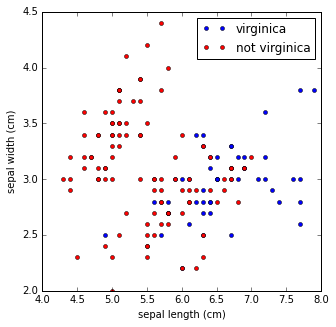

In [0]:
#@title This is how our data looks like { run: "auto", vertical-output: true }
# First we load the IRIS data, a classical data for classification task.
# We choose to focus on two features, and two targets
# you can choose different features to play!
features = [0, 1] # index of features to focus
target   = 2    # index of targets  to set to positive
iris = datasets.load_iris()
X = iris.data[:, features]
y = iris.target

# We will set label where y = target to  1
# And         label where y = target to -1
y[np.where(np.not_equal(y, target))] = -1
y[np.where(    np.equal(y, target))] =  1

# Let's see how our data looks like
fig0 = plt.figure(0, figsize=(5,5))
ax = plt.gca()
plot_data(ax, X, y)
plt.show()


## Next, we will learn a SVM classifier, and visualize the ROC curve

First, we will learn a SVM classifier with C = 0.001, then gradually change move the decision boundary \\
to see how it affects our recall and precision. 

**How to use**: Gradually move the bar moving_percentage to move the decision boundary to see the changes \\
Data points with the round border are misclassfications. You have to change the value gradually to have a nice \\
ROC curve! The AUC value will be shown when moving_percentage is set to 100%.

**Note: To reset the ROC:**
1.   Set the reset_the_roc to Yes
2.   Then, Set the reset_the_roc to No (This is IMPORTANT!)

In [0]:
# Let's learn a SVM classifier with C = 0.01
clf = svm.SVC(kernel='linear', C=0.01, random_state=3).fit(X,y)
decision_biases = list(set([clf.decision_function([x])[0] for x in X]))
decision_biases.sort(reverse=True)
min_bias = np.min(decision_biases)
max_bias = np.max(decision_biases)
fprs = [0]
tprs = [0]

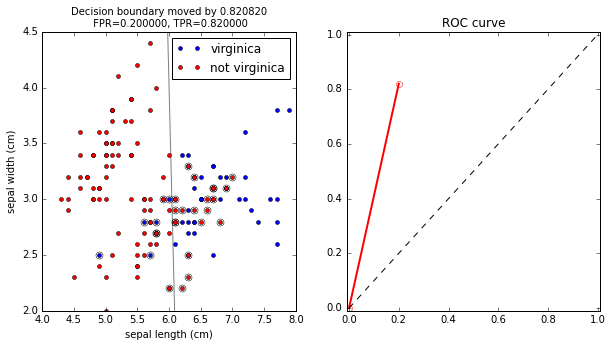

In [0]:
#@title Move the slider to change the intercept { run: "auto", vertical-output: true }
moving_percentage = 50 #@param {type:"slider", min:0, max:100, step:2}
intercept = max_bias - ((max_bias - min_bias) * moving_percentage / 100)

reset = "RESET"
reset_the_roc = "Yes" #@param ["Yes", "No"]
if reset_the_roc == "Yes":
  fprs = [0]
  tprs = [0]
  reset_the_roc = "No"

  
def plot(intercept):
    # First we calculate the TP, FP, TN, FN
    decision_values = clf.decision_function(X) - intercept
    masks = mask(decision_values, y)
    p_mask, n_mask, t_mask, f_mask = masks
    ax[0].cla()
    plot_data(ax[0],X, y)
    plot_mispredictions(ax[0], f_mask)
    
    # Next, let's find the true positive rate and false positive rate
    fpr, tpr = cal_roc_elements(p_mask, n_mask, t_mask, f_mask)
    fprs.append(fpr)
    tprs.append(tpr)
    fprs.sort()
    tprs.sort()
    plot_roc(ax[1], fprs, tprs)

    # Get and plot the separating hyperplane
    Z = clf.decision_function(xy).reshape(XX.shape) - intercept
    cont = ax[0].contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, 
                         linestyles=['-'])
    
    ax[0].set_title('Decision boundary moved by %f\n FPR=%f, TPR=%f' % 
                    (-intercept, fpr, tpr), fontsize=10)
    return cont


fig2, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_data(ax[0], X, y)
XX, YY, xy = create_mesh(ax[0])
plot(intercept)
plt.show()


## Now, we learn how to tune the parameter using the AUC scores

Best value of parameter C: 0.1
Accuracy on the test data: 0.8666666666666667


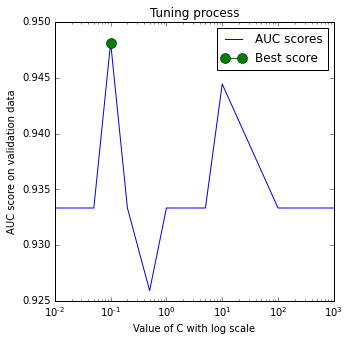

In [0]:
#@title This is how the tuning process looks like { run: "auto", vertical-output: true }
# First, we split the data into 3 parts TRAIN / VALIDATION / TEST
X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=1) 
X_tr    , X_val , y_tr    , y_val  = train_test_split(X_tr_val, y_tr_val, 
                                                      test_size=0.2, 
                                                      random_state=1)

# Then learn the data with TRAIN data
# And get the AUC score for VALIDATION data
c_values  = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100, 1000]
aucs      = []
for c_value in c_values:
    clf      = svm.SVC(kernel='linear', 
                       C=c_value, probability=True, random_state=5).fit(X_tr,y_tr)
    val_prob = clf.predict_proba(X_val)
    auc      = roc_auc_score(y_val, val_prob[:, 1])
    aucs.append(auc)

# Finally, we get the parameter with the bets AUC score
# And relearn with TRAIN + VALIDATION data
best_c_index = np.argmax(aucs)
best_clf     = svm.SVC(kernel='linear', 
                       C=c_values[best_c_index]).fit(X_tr_val, y_tr_val)
test_predict = best_clf.predict(X_test)
print("Best value of parameter C:", c_values[best_c_index])
print("Accuracy on the test data:", accuracy_score(y_test, test_predict))
    
# ======================================================
#                     VISUALIZATION
# ======================================================
fig2 = plt.figure(figsize=(5,5))
ax   = plt.gca()
# Plot the tuning process
ax.semilogx(c_values, aucs, label = 'AUC scores')
ax.semilogx(c_values[best_c_index], aucs[best_c_index], 
            marker='o', markersize=10, label='Best score')
ax.set_xlabel('Value of C with log scale')
ax.set_ylabel('AUC score on validation data')
ax.set_title('Tuning process')
ax.legend()
plt.show()

### Let's see the prediction with training data and test data

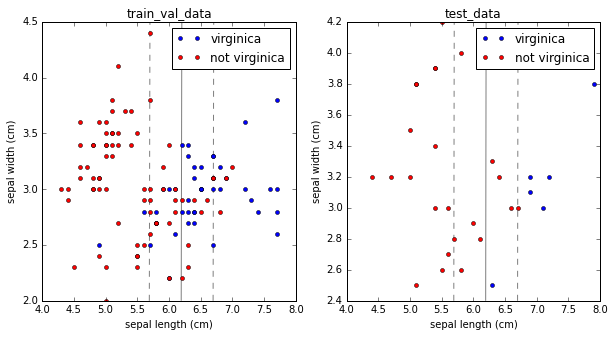

In [0]:
#@title The prediction with training and test data { run: "auto", vertical-output: true }
# Plot the prediction result with train_val_data
fig3, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_data(ax[0], X_tr_val, y_tr_val)
XX, YY, xy = create_mesh(ax[0])
Z = clf.decision_function(xy).reshape(XX.shape)
cont = ax[0].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
                     alpha=0.5, linestyles=['--','-','--'])
ax[0].set_title('train_val_data')

# Plot the prediction result with test_data
plot_data(ax[1], X_test, y_test)
XX, YY, xy = create_mesh(ax[1])
Z = clf.decision_function(xy).reshape(XX.shape)
cont = ax[1].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
                     alpha=0.5, linestyles=['--','-','--'])
ax[1].set_title('test_data')
plt.show()

## Finally, let's take a look at how changing the parameter affects the SVM classifier

You will see that the larger the parameter is, the smaller the margin becomes

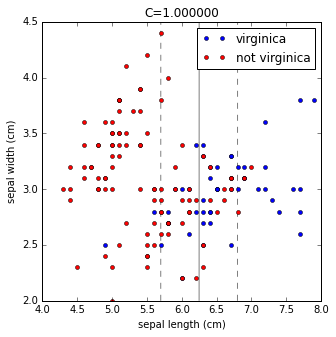

In [0]:
#@title Change reg_param (the actual value is reg_param/100) { run: "auto", vertical-output: true }
reg_param = "1" #@param ["0.01", "0.05", "0.1", "0.5", "1", "10", "100", ""]
fig4 = plt.figure(4, figsize=(5,5))
ax = plt.gca()
plot_data(ax ,X, y)
XX, YY, xy = create_mesh(ax)
cont = None

# Now we define the animation function
def plot(reg_param):
    global cont
    clf = svm.SVC(kernel='linear', C=reg_param).fit(X, y)
    # Remove the current contours
    if cont != None:
        for c in cont.collections:
            c.remove()
    # get the separating hyperplane
    Z = clf.decision_function(xy).reshape(XX.shape)
    # plot decision boundary and margins
    cont = ax.contour(XX, YY, Z, colors='k', levels=[-1,0,1], 
                      alpha=0.5, linestyles=['--','-','--'])
    
    plt.title('C=%f' % (reg_param))
    return cont

plot(float(reg_param))
plt.show()
